In [17]:
import os
import scanpy as sc
import pandas as pd
import numpy as np
import json

In [2]:
from src import sprout
import warnings
warnings.filterwarnings("ignore")

# 1. Load files

In [3]:
inputDir = './demo/'
sc_exp = pd.read_csv(f'{inputDir}/SC_exp.tsv',sep = '\t',header=0,index_col=0)
sc_meta = pd.read_csv(f'{inputDir}/SC_meta.tsv',sep = '\t',header=0,index_col=0)
st_exp = pd.read_csv(f'{inputDir}/ST_exp.tsv',sep = '\t',header=0,index_col=0)
st_coord = pd.read_csv(f'{inputDir}/ST_coord.tsv',sep = '\t',header=0,index_col=0)
st_decon = pd.read_csv(f'{inputDir}/ST_decon.tsv',sep = '\t',header=0,index_col=0)
lr_df = pd.read_csv('./LR/mouse_LR_pairs.txt',sep='\t',header=None)

# 2.Run sprout

In [5]:
save_path = './demo/demo_results/'

In [6]:
st_exp.index = st_exp.index.map(str)
st_decon.index = st_decon.index.map(str)
st_coord.index = st_coord.index.map(str)

In [33]:
num_per_spot = 10
repeat_penalty = (st_exp.shape[0] * num_per_spot/sc_exp.shape[0]) * 10 

In [7]:
%%time
sprout_obj = sprout.SPROUT(st_exp = st_exp, st_coord = st_coord, weight = st_decon, 
        sc_exp = sc_exp, meta_df = sc_meta, cell_type_key = 'celltype',lr_df = lr_df,
        save_path = save_path)
spot_cor,picked_index_df = sprout_obj.select_sc(num_per_spot = num_per_spot, mode = 'strict', max_rep = 1, repeat_penalty = repeat_penalty)
sc_coord = sprout_obj.spatial_recon(left_range = 0, right_range = 10, steps = 1, dim = 2,max_dist = 1)

Calculating Filtering...
Calculated Filtering in 0.02 seconds.
Calculating Feature selection...
  - Given the user-defined parameter keep_lr_per, STORM kept 80%, that is, 80 highly variable LR genes.
  - STORM selects 882 feature genes.
Calculated Feature selection in 1.10 seconds.
Calculating Initial cell selection...
	 Init solution: max - 1.00,     mean - 0.96,     min - 0.69
Calculated Initial cell selection in 5.76 seconds.
Calculating Swap...
	 Swapped solution: max - 1.00,     mean - 0.98,     min - 0.76
Calculated Swap in 25.33 seconds.
Calculating Affinity...
Calculated Affinity in 0.24 seconds.
Avearge shape correlation is: 0.9635371197935331
Avearge shape correlation is: 0.9686478840548474
Avearge shape correlation is: 0.9704114832766756
Avearge shape correlation is: 0.9715769506238988
Avearge shape correlation is: 0.9728929765911828
Avearge shape correlation is: 0.9717947715735032
Avearge shape correlation is: 0.972048315297871
Avearge shape correlation is: 0.97498863338218

In [18]:
sc_agg_exp = sc_exp.loc[sprout_obj.picked_index_df['sc_id']]
sc_agg_exp = sc_agg_exp.reset_index()
sc_agg_exp.to_csv(f'{save_path}/sc_agg_exp.tsv',sep = '\t',header=True,index=True)

# 3.Visualization

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
def draw(coord,tp,save_path,hue_order,title = 'Single-cell reconstruction'):
    coord = np.array(coord)
    coord_df = pd.DataFrame(coord,columns = ['x','y'])
    coord_df['tp'] = tp.values
    cdmap = 'Paired'
    fig = plt.figure(figsize=(8,8))
    plt.title(title)
    sns.scatterplot(data=coord_df, x='x', y='y', hue='tp',palette=cdmap,hue_order = hue_order)
    plt.axis('equal')
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)
    plt.show()
    #plt.savefig(f'{save_path}/center_shift_coord.pdf')

In [9]:
tp_list = list(set(picked_index_df['celltype']))
tp_list.sort()

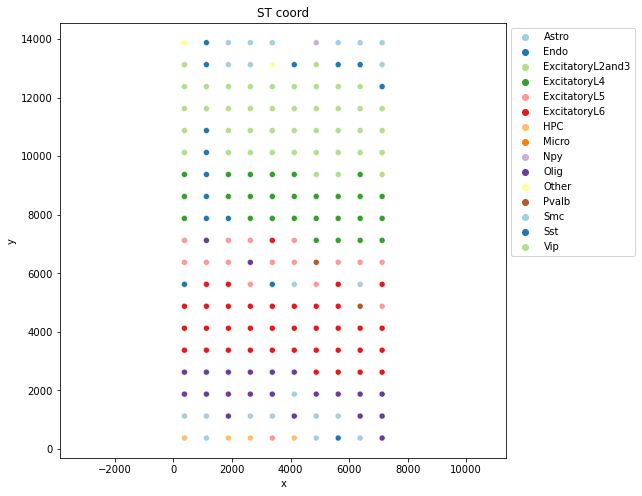

In [10]:
st_meta = st_decon.idxmax(axis = 1)
draw(st_coord, st_meta,save_path,tp_list,'ST coord')

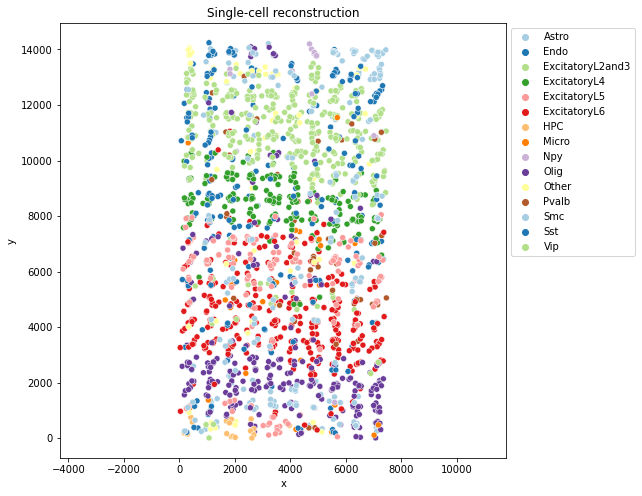

In [11]:
draw(sc_coord,picked_index_df['celltype'],save_path,tp_list)

# 4. Ground Truth

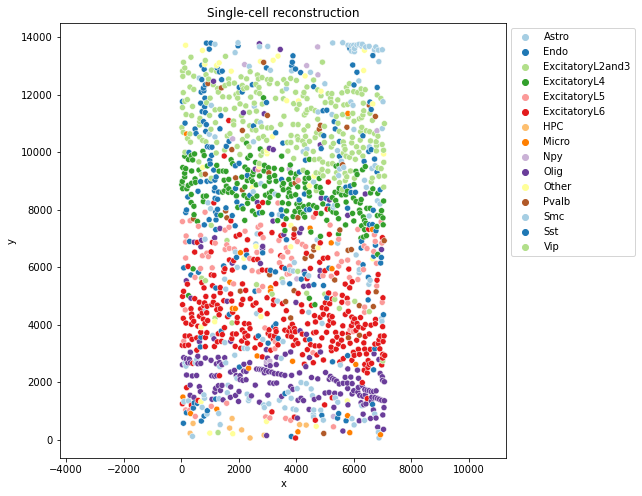

In [12]:
gd_coord = pd.read_csv(f'{inputDir}/ground_truth_coord.tsv',sep = '\t',header=0,index_col=None)
draw(gd_coord,sc_meta['celltype'],save_path,tp_list)